# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [71]:
# Run some setup code for this notebook.
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [72]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


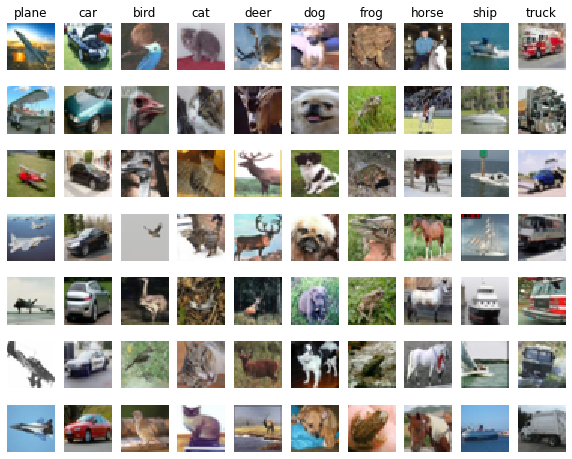

In [73]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [74]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [75]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


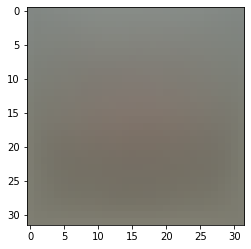

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [76]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [303]:
# Evaluate the naive implementation of the loss we provided for you:
from comp411.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print(grad)

loss: 9.013258
[[-1.31139051e+01 -9.49097224e+00  3.59529633e+00 ... -2.43407824e+01
   6.60404654e-01 -3.94533375e+01]
 [-2.26569133e+01 -2.14219184e+00  3.36892245e+00 ... -2.59120184e+01
  -9.70173510e+00 -4.44969863e+01]
 [-3.89943041e+01 -5.69312980e+00  1.59341731e+01 ... -2.53497380e+01
  -2.53347659e+01 -5.44824084e+01]
 ...
 [-8.13090204e+00 -7.12456490e+00  4.24808653e+00 ... -1.88223690e+01
   1.12931171e+01 -1.43774542e+01]
 [-1.44520214e+01 -1.63980514e+01  1.22240686e+01 ... -7.83409429e+00
  -7.34554686e+00 -2.00564231e+01]
 [-4.99999999e-02 -1.20000000e-01  1.60000000e-01 ... -2.20000000e-01
   1.23999999e-01 -5.39999994e-02]]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [304]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -23.457374 analytic: -23.457374, relative error: 6.933641e-12
numerical: -8.651609 analytic: -8.651609, relative error: 2.098483e-12
numerical: 5.033006 analytic: 5.033006, relative error: 1.347354e-11
numerical: -13.674350 analytic: -13.674350, relative error: 7.581150e-12
numerical: 7.668407 analytic: 7.668407, relative error: 1.434405e-11
numerical: 20.971371 analytic: 20.971371, relative error: 1.989694e-13
numerical: 10.135569 analytic: 10.135569, relative error: 5.584019e-11
numerical: -2.316968 analytic: -2.316968, relative error: 7.240229e-11
numerical: 4.473252 analytic: 4.473252, relative error: 4.111937e-11
numerical: -7.291824 analytic: -7.291824, relative error: 1.656587e-11
numerical: 10.950914 analytic: 10.944446, relative error: 2.954043e-04
numerical: 8.916118 analytic: 8.909493, relative error: 3.716387e-04
numerical: 6.045436 analytic: 6.019662, relative error: 2.136212e-03
numerical: 21.690753 analytic: 21.688755, relative error: 4.605343e-05
numerical: -

## Modified Huber Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

The Modified Huber Loss implementaiton should be similar to SVM Hinge Loss.

In [334]:
# Now implement and Evaluate the naive implementation of the huber loss:
from comp411.classifiers.linear_svm import huber_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print(grad)

loss: 10.642120
[[-2.53352032e+01 -5.11802096e+01 -1.44460922e+01 ...  1.26674097e+00
   3.76141465e+01 -1.37102205e+02]
 [-3.59947130e+01 -4.16876440e+01 -1.38074899e+01 ... -1.08101792e+00
   1.71436242e+01 -1.45167463e+02]
 [-5.80297840e+01 -5.16886894e+01  1.33749668e+01 ...  4.79505767e+00
  -1.42531711e+01 -1.66276490e+02]
 ...
 [-2.74975374e+01 -1.62277386e+01 -1.22275518e+01 ...  1.94930130e+01
   4.25953709e+01 -8.05079254e+01]
 [-2.69375658e+01 -3.81042127e+01  3.99457698e+00 ...  5.19545978e+01
   8.66377201e-01 -9.71792582e+01]
 [-1.02051594e-02 -2.58196096e-01  2.73708590e-01 ... -6.07376053e-01
   2.41866912e-01 -1.45441113e-01]]


In [335]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = huber_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 18.241523 analytic: 18.241523, relative error: 1.083380e-11
numerical: 22.839242 analytic: 22.839242, relative error: 7.529545e-13
numerical: 30.912024 analytic: 30.912024, relative error: 5.930149e-12
numerical: 1.019030 analytic: 1.019030, relative error: 2.105037e-10
numerical: 34.372237 analytic: 34.372237, relative error: 1.752365e-12
numerical: -56.026024 analytic: -56.026024, relative error: 2.978708e-12
numerical: 10.078493 analytic: 10.078493, relative error: 3.419901e-11
numerical: -36.382815 analytic: -36.382815, relative error: 8.713435e-12
numerical: 8.778520 analytic: 8.778520, relative error: 3.555508e-11
numerical: 46.754805 analytic: 46.754805, relative error: 8.252087e-14
numerical: 45.634502 analytic: 45.634502, relative error: 2.430368e-12
numerical: 60.955476 analytic: 60.955476, relative error: 4.622426e-12
numerical: 61.296572 analytic: 61.296572, relative error: 5.884330e-12
numerical: 34.808885 analytic: 34.808885, relative error: 7.049112e-12
numeri

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *The contradiction arising here is due to the structure of the SVM function. When calculating the loss of this function; We do max(0,predicted_score - correct_score + 1). The problem here is that the process is not fully differentiable when calculating gradients. For example; When "predicted_score - correct_score + 1"=0, a non-differentiable function is obtained. This non-differentiable part is called "kinks". However, this may not be a major concern. Because the probability of this happening is very low. Nevertheless, these parts can be omitted for a more accurate calculation. For example, if the numerical gradient value is less than the calculated value, the gradient check may fail. As a numerical example, let's say "predicted_score - correct_score + 1"=-1e-9. When the max operation is performed, the output will be 0 because 0 is greater than this number. This will make the gradient check fail. In this case, increasing the margin value can prevent possible failure situations.*  


In [307]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.010392e+00 computed in 0.132255s
Vectorized loss: 9.010392e+00 computed in 0.003990s
difference: 0.000000


In [308]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.135638s
Vectorized loss and gradient: computed in 0.002995s
difference: 0.000000


In [339]:
# Next implement the function huber_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import huber_loss_vectorized
tic = time.time()
loss_vectorized, _ = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.064212e+01 computed in 0.146544s
Vectorized loss: 1.064212e+01 computed in 0.003991s
difference: 0.000000


In [338]:
# Complete the implementation of huber_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.157579s
Vectorized loss and gradient: computed in 0.006997s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [311]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from comp411.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 410.380431
iteration 100 / 1500: loss 243.114014
iteration 200 / 1500: loss 147.516088
iteration 300 / 1500: loss 90.639685
iteration 400 / 1500: loss 55.869157
iteration 500 / 1500: loss 36.294756
iteration 600 / 1500: loss 24.191259
iteration 700 / 1500: loss 15.617288
iteration 800 / 1500: loss 11.855218
iteration 900 / 1500: loss 8.884504
iteration 1000 / 1500: loss 7.470040
iteration 1100 / 1500: loss 6.409719
iteration 1200 / 1500: loss 5.953915
iteration 1300 / 1500: loss 5.603482
iteration 1400 / 1500: loss 5.203561
That took 7.001874s


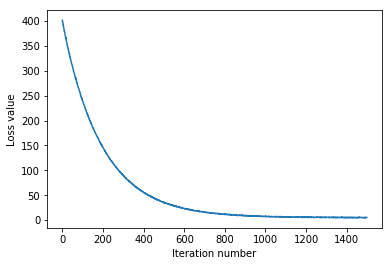

In [94]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [54]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.379265
validation accuracy: 0.384000


### Stochastic Gradient Descent
We also have vectorized and efficient expressions for the huber loss, the gradient and our gradient matches the numerical gradient. Thus, we are also ready to do SGD to minimize the huber loss.

In [340]:
from comp411.classifiers import LinearHuber
huber = LinearHuber()
tic = time.time()

loss_hist = huber.train(X_train, y_train, learning_rate=3e-7, reg=0,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 71.418091
iteration 100 / 1500: loss 16.416659
iteration 200 / 1500: loss 15.532094
iteration 300 / 1500: loss 17.890950
iteration 400 / 1500: loss 10.674356
iteration 500 / 1500: loss 11.169620
iteration 600 / 1500: loss 8.605648
iteration 700 / 1500: loss 8.201175
iteration 800 / 1500: loss 10.124343
iteration 900 / 1500: loss 9.574413
iteration 1000 / 1500: loss 9.751928
iteration 1100 / 1500: loss 12.625589
iteration 1200 / 1500: loss 8.437892
iteration 1300 / 1500: loss 7.675780
iteration 1400 / 1500: loss 8.669446
That took 6.411144s


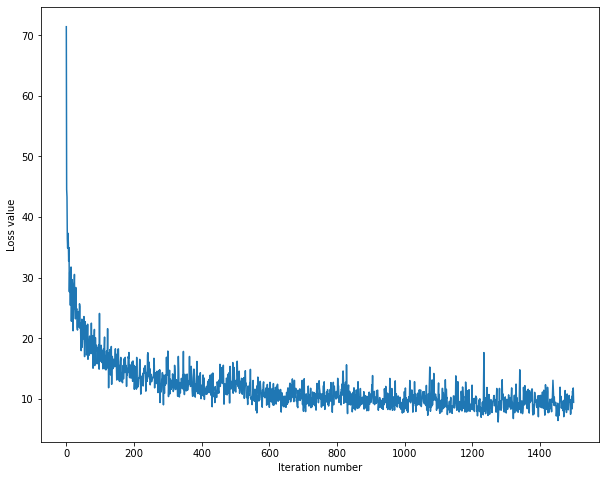

In [341]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [342]:
# Lets evaluate the performance on both the
# training and validation set
y_train_pred = huber.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = huber.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

## at minumim, you should see accuracy results around 0.25

training accuracy: 0.318837
validation accuracy: 0.312000


In [347]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate) and loss type (svm hinge or modified huber). You should experiment
# with different ranges for the learning rates and regularization strengths and cases
# for the loss type. If you are careful you should be able to
# get a classification accuracy of about 0.39 or higher on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug however you may want to add 
# safety margins for possible overflow/underflow causing operations in your .py implementations.

#Note: you may want to observe the behavioral differences between standard
#      svm hinge loss and modified huber loss

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength, loss_type) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best = None #  The LinearSVM or LinearHuber object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        
# Write code that chooses the best hyperparameters by tuning on the validation 
# set. For each combination of hyperparameters, train a linear SVM and a linear
# Huber on the training set, compute their accuracy on the training and 
# validation sets, and store these numbers in the results dictionary. In 
# addition, store the best validation accuracy in best_val and the LinearSVM 
# or LinearHuber object that achieves this, accuracy in best.    
#                                
#                                                                              
# Hint: You should use a small value for num_iters as you develop your         
# validation code so that the SVMs don't take much time to train; once you are 
# confident that your validation code works, you should rerun the validation   
# code with a larger value for num_iters.                                      
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]
loss_types = ["SVM", "Huber"]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [ (lr,rg,lt) for lr in learning_rates for rg in regularization_strengths for lt in loss_types ]

for lr, rg, lt in grid_search:
    if lt== 'SVM':
        svm = LinearSVM()
    elif lt=='Huber':
        svm=LinearHuber()
        
    # Train the model with current parameters
    train_loss = svm.train(X_train, y_train, learning_rate=lr, reg=rg, num_iters=1500, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Save results
    results[(lr,rg, lt)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best= svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg, lt in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, lt)]
    print('lr %e reg %e type %s train accuracy: %f val accuracy: %f' % (
                lr, reg, lt, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\ecesu\OneDrive\Desktop\KOC_University\comp511\comp-511-main\comp511_assignment1_EA_GK\comp411\classifiers\linear_svm.py:230: RuntimeWarning: invalid value encountered in subtract
  margin[np.arange(num_train),y] = 0.0
C:\Users\ecesu\OneDrive\Desktop\KOC_University\comp511\comp-511-main\comp511_assignment1_EA_GK\comp411\classifiers\linear_svm.py:231: RuntimeWarning: invalid value encountered in subtract
  


lr 1.000000e-07 reg 2.500000e+04 type Huber train accuracy: 0.372429 val accuracy: 0.376000
lr 1.000000e-07 reg 2.500000e+04 type SVM train accuracy: 0.378776 val accuracy: 0.388000
lr 1.000000e-07 reg 5.000000e+04 type Huber train accuracy: 0.347388 val accuracy: 0.332000
lr 1.000000e-07 reg 5.000000e+04 type SVM train accuracy: 0.371959 val accuracy: 0.369000
lr 5.000000e-05 reg 2.500000e+04 type Huber train accuracy: 0.086653 val accuracy: 0.081000
lr 5.000000e-05 reg 2.500000e+04 type SVM train accuracy: 0.159449 val accuracy: 0.173000
lr 5.000000e-05 reg 5.000000e+04 type Huber train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 5.000000e+04 type SVM train accuracy: 0.081122 val accuracy: 0.093000
best validation accuracy achieved during cross-validation: 0.388000


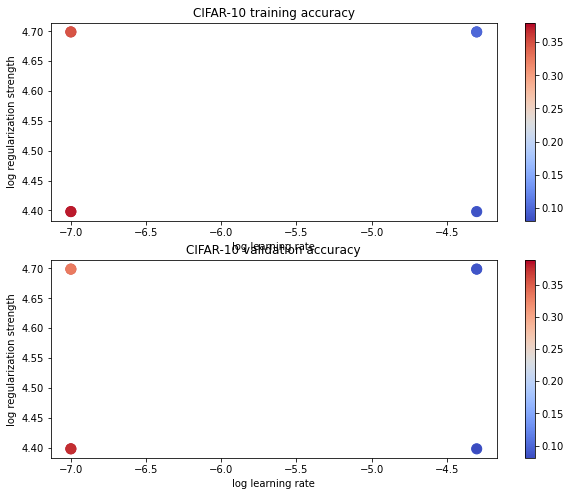

In [348]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [349]:
# Evaluate the best linear classifier on test set
y_test_pred = best.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear classifier on raw pixels final test set accuracy: %f' % test_accuracy)

linear classifier on raw pixels final test set accuracy: 0.368000


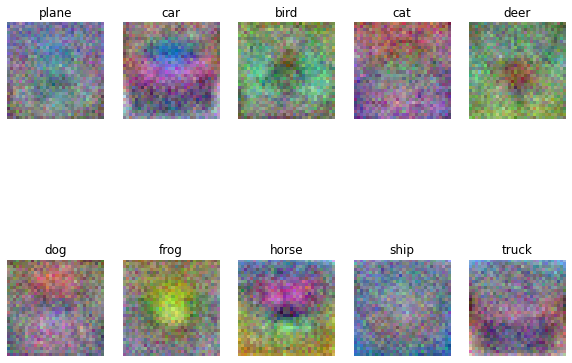

In [350]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized linear classifier weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
